<a href="https://colab.research.google.com/github/IzaakGagnon/SSC_GliderProject/blob/main/Test_code/GWR_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mgwr
!pip install tables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.2/388.2 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.9/398.9 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.1/506.1 kB 26.2 MB/s eta 0:00:00


In [2]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores available: {num_cores}")

Number of CPU cores available: 96


In [7]:
# Uncomment and run the next line if mgwr is not already installed:
#!pip install mgwr
#!pip install tables
import pandas as pd
import numpy as np
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from sklearn.preprocessing import StandardScaler
# Load the dataset
df = pd.read_hdf('/content/drive/MyDrive/Glider data/glider_data.h5')
pp = len(df)
prop = 0.001
df = df.sample(frac = prop)
print(len(df), "/", pp)
df[['longitude','latitude']] = df[['longitude','latitude']].astype(np.float64)

# Inspect the first few rows and columns to confirm variable names
print("Dataset preview:")
print(df.head())
print("\nColumns in the dataset:", df.columns.tolist())
# -------------------------------
# Define your variables:
# -------------------------------
# We'll use 'sea_water_temperature' as the response variable.
# Exclude 'time', 'latitude', and 'longitude' from predictors.
response_variable = 'oxygen'
predictor_cols = [col for col in df.columns if col not in ['time','latitude','longitude', response_variable]]
print("\nResponse variable selected:", response_variable)
print("Predictor columns selected:", predictor_cols)

# Extract coordinates, response, and predictors
# Note: The coordinate order is typically [longitude, latitude]
coords = df[['longitude', 'latitude']].values
y = df[response_variable].values.reshape((-1, 1))
X = df[predictor_cols].values

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Standardize predictors
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Apply PCA to standardized data
pca = PCA()
X_pca = pca.fit_transform(X_standardized)

# Determine the number of components needed to explain 99% variance
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
n_components = np.argmax(explained_variance_ratio >= 0.95) + 1  # Get minimum number of components

print(f"\nNumber of Principal Components Retaining 95% of Variance: {n_components}")

# Apply PCA again with the chosen number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_standardized)

# Print the Principal Component Coefficients (Loadings)
print("\nPrincipal Components (PC Loadings):")
pc_loadings = pd.DataFrame(pca.components_, columns=predictor_cols, index=[f"PC{i+1}" for i in range(n_components)])
print(pc_loadings)

# Convert PCs into DataFrame
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)])


# Step 2: Bandwidth Selection for MGWR
bw_selector = Sel_BW(coords, y, X_pca, multi=False,fixed = False,spherical = True, kernel='bisquare',n_jobs = 8)
print("Searching for bw")
bw = bw_selector.search()  # Perform the search and assign the bandwidths

print("Bandwidth selected:", bw)
# Step 3: Fit the MGWR Model (Use `bw_selector`, now properly assigned)
mgwr_model = GWR(coords, y, X_pca, bw, fixed = False)
mgwr_results = mgwr_model.fit()
print(mgwr_results.summary())




bw_selector2 = Sel_BW(coords, y, X_pca, multi=True,fixed = False,spherical = True, kernel='bisquare',n_jobs = 8)
print("Searching for bw2")
bw = bw_selector2.search(init_multi=int(bw))  # Perform the search and assign the bandwidths
print("Bandwidth selected:", bw)
# Step 4: Output MGWR Summary
print("\nMGWR Model Summary:")
print(mgwr_results.summary())

# Step 5: Extract and display local parameter estimates
local_params = mgwr_results.params
print("\nLocal parameter estimates (first 5 observations):")
print(local_params[:5])

10357 / 10356849
Dataset preview:
                        time   latitude  longitude       depth  temperature  \
9378875  2023-07-28 11:21:47  47.716343 -63.752781   52.257381      0.98840   
1138909  2022-06-09 17:20:50  47.508015 -63.385212   18.691837      7.14980   
3264008  2023-10-07 14:59:41  48.517925 -62.104084   55.793125      1.21365   
4491738  2022-06-26 10:57:01  48.311344 -61.556858   57.638954      0.32270   
2314241  2023-08-08 18:10:36  49.214878 -63.846771  118.483559      2.13950   

          salinity      density      oxygen  
9378875  31.711636  1025.656372  261.639038  
1138909  29.913797  1023.485107  276.570648  
3264008  31.737658  1025.680664  270.694427  
4491738  31.839565  1025.821899  277.989105  
2314241  32.748005  1026.723511  215.908585  

Columns in the dataset: ['time', 'latitude', 'longitude', 'depth', 'temperature', 'salinity', 'density', 'oxygen']

Response variable selected: oxygen
Predictor columns selected: ['depth', 'temperature', 'salinity'

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

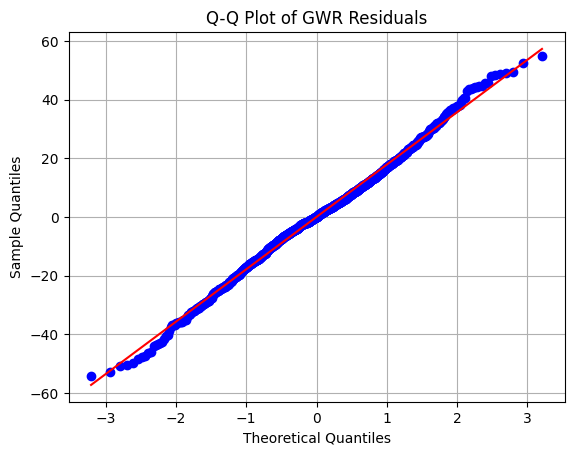

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Extract residuals from the GWR model
residuals = mgwr_results.resid_response.flatten()  # Flatten to 1D

# Generate Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt, )

# Customize the plot
plt.title("Q-Q Plot of GWR Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)

# Show the plot
plt.show()


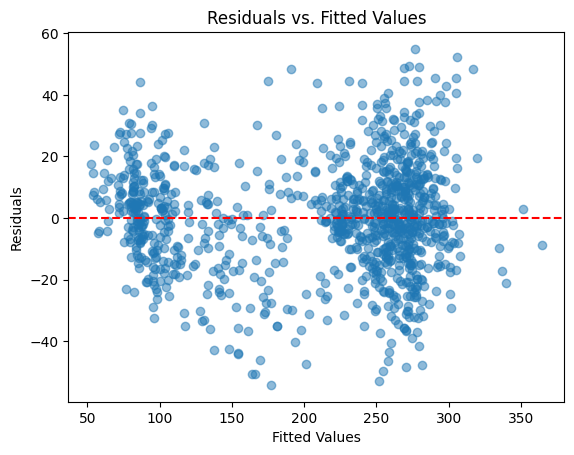

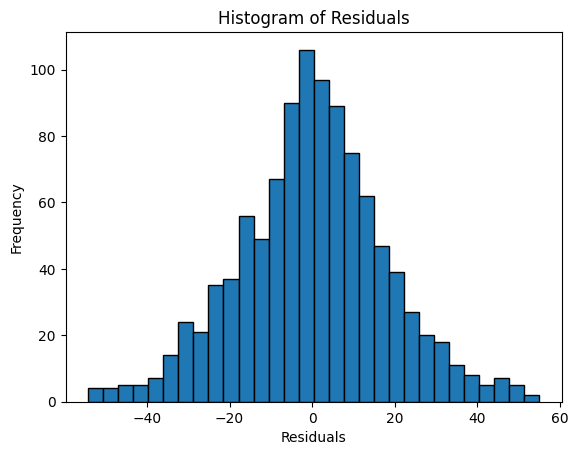

Shapiro-Wilk test statistic: 0.9958184857868283, p-value: 0.0064808878898185


In [ ]:
import matplotlib.pyplot as plt
plt.scatter(mgwr_results.predy.flatten(), mgwr_results.resid_response.flatten(), alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

plt.hist(mgwr_results.resid_response.flatten(), bins=30, edgecolor='k')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

from scipy.stats import shapiro
stat, p_value = shapiro(mgwr_results.resid_response.flatten())
print(f"Shapiro-Wilk test statistic: {stat}, p-value: {p_value}")


In [ ]:
# Install dependencies if needed
#!pip install pykrige scikit-learn pandas numpy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load the Dataset
df = pd.read_hdf('/content/drive/MyDrive/Glider data/glider_data.h5')

# Step 2: Subsample for Speed
prop = 0.001  # Adjust if necessary
df = df.sample(frac=prop, random_state=42)
df[['longitude', 'latitude']] = df[['longitude', 'latitude']].astype(np.float64)

# Step 3: Define response variable and predictors
response_variable = 'oxygen'
predictor_cols = [col for col in df.columns if col not in ['time', 'latitude', 'longitude', response_variable]]

# Extract data
coords = df[['longitude', 'latitude']].values
y = df[response_variable].values.reshape(-1, 1)
X = df[predictor_cols].values

# Step 4: Standardize predictors
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Step 5: Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_standardized)
n_components = X_pca.shape[1]

print(f"Optimal number of PCA components: {n_components}")

# Step 6: Ridge Regression with Cross-Validation
alpha_values = np.logspace(-4, 4, 50)
ridge_cv = RidgeCV(alphas=alpha_values, store_cv_results=True)
ridge_cv.fit(X_pca, y)
y_pred_reg = ridge_cv.predict(X_pca)

print(f"Optimal Ridge Alpha: {ridge_cv.alpha_}")

# Step 7: Compute residuals
residuals = y.flatten() - y_pred_reg.flatten()

# Step 8: Apply Kriging on residuals
print("\nFitting Kriging model on residuals...")
variogram_models = ["spherical", "exponential", "gaussian", "linear", "power"]
best_model = None
best_score = float('inf')
best_OK = None

for model in variogram_models:
    try:
        OK = OrdinaryKriging(df['longitude'].values, df['latitude'].values, residuals, variogram_model=model)
        residuals_kriged, _ = OK.execute("points", df['longitude'], df['latitude'])
        score = np.var(residuals - residuals_kriged)

        print(f"Variogram model: {model}, Residual Variance: {score:.6f}")

        if score < best_score:
            best_score = score
            best_model = model
            best_OK = OK
    except Exception as e:
        print(f"Variogram model {model} failed: {str(e)}")

print(f"\nBest variogram model selected: {best_model}")

# Step 9: Compute final predictions
residuals_kriged, _ = best_OK.execute("points", df['longitude'], df['latitude'])
df['oxygen_reg_kriged'] = y_pred_reg.flatten() + residuals_kriged

# Save the processed dataset
df.to_csv("ridge_regression_kriging_results.csv", index=False)
print("\nRegression-Kriging results saved.")

# Step 10: Train-Test Split (80%-20%)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Extract actual and predicted values for train and test sets
y_train_actual = train_df["oxygen"].values
y_train_pred = train_df["oxygen_reg_kriged"].values
y_test_actual = test_df["oxygen"].values
y_test_pred = test_df["oxygen_reg_kriged"].values

# Compute error metrics for train and test sets
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

mae_train = mean_absolute_error(y_train_actual, y_train_pred)
mae_test = mean_absolute_error(y_test_actual, y_test_pred)

r2_train = r2_score(y_train_actual, y_train_pred)
r2_test = r2_score(y_test_actual, y_test_pred)

# Adjusted R² Calculation
p = n_components  # Number of PCA components used
n_train = len(y_train_actual)
n_test = len(y_test_actual)

adjusted_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p - 1))
adjusted_r2_test = 1 - ((1 - r2_test) * (n_test - 1) / (n_test - p - 1))

# Step 11: Prepare Summary Table
summary_train_test = pd.DataFrame([
    {"Set": "Train", "RMSE": rmse_train, "MAE": mae_train, "R²": r2_train, "Adjusted R²": adjusted_r2_train},
    {"Set": "Test", "RMSE": rmse_test, "MAE": mae_test, "R²": r2_test, "Adjusted R²": adjusted_r2_test}
])

# Display performance metrics
print("\nModel Performance Summary:")
print(summary_train_test)

# Step 12: Visualizations
plt.figure(figsize=(12, 5))

# Residuals Plot
plt.subplot(1, 2, 1)
residuals = y_actual - y_pred
plt.scatter(y_actual, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual Oxygen")
plt.ylabel("Residuals")
plt.title("Residuals vs Actual Oxygen")

# Predictions vs Actual Plot
plt.subplot(1, 2, 2)
plt.scatter(y_actual, y_pred, alpha=0.5)
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], 'r--')  # 1:1 line
plt.xlabel("Actual Oxygen")
plt.ylabel("Predicted Oxygen")
plt.title("Predicted vs Actual Oxygen")

plt.tight_layout()
plt.show()

# Check for overfitting
if rmse_test > rmse_train * 1.2:
    print("\n⚠️ Overfitting Detected: Test RMSE is significantly higher than Train RMSE.")
else:
    print("\n✅ No major overfitting detected.")

# Save summary
summary_train_test.to_csv("model_performance_summary.csv", index=False)
print("\nModel performance summary saved.")


Optimal number of PCA components: 2
Optimal Ridge Alpha: 0.5689866029018293

Fitting Kriging model on residuals...
Variogram model: spherical, Residual Variance: 3.507765
Variogram model: exponential, Residual Variance: 2.861992
Variogram model: gaussian, Residual Variance: 4.162613
